<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
import pandas as pd
%config Completer.use_jedi = False

from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
import numpy as np
from functools import partial

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 1200 results
transitions_data returned 2980 results


crime_type  compartment  outflow_to
RAPE        pretrial     jail          66.666667
dtype: float64%


total_population_data returned 0 results
initialization time:  91.08334302902222
simulation_time:  108.54984283447266
initialization time:  87.78760981559753
simulation_time:  105.47063493728638
initialization time:  88.31875205039978
simulation_time:  105.1681079864502


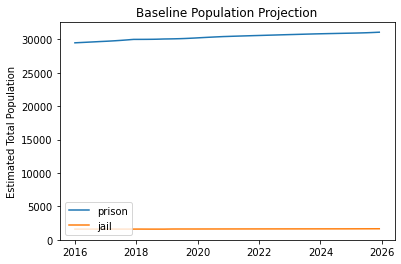

In [3]:
path_from_state_folder = 'VA/2022/VA_2022_testing_model_inputs.yaml'
display_compartments = ['prison', 'jail']
test_sim = SuperSimulationFactory.build_super_simulation('../state/' + path_from_state_folder)
test_sim.simulate_baseline(display_compartments)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/validator.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=fig_size)


[<AxesSubplot:title={'center':'simulation_group: ASSAULT\ncompartment: pretrial\noutflow_to: jail'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASSAULT\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARY/DWELLING\ncompartment: pretrial\noutflow_to: jail'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARY/DWELLING\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARY/OTHER\ncompartment: pretrial\noutflow_to: jail'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: BURGLARY/OTHER\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DRUG OTHER\ncompartment: pretrial\noutflow_to: jail'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DRUG OTHER\ncompartment: pretrial\noutflow_to: prison'

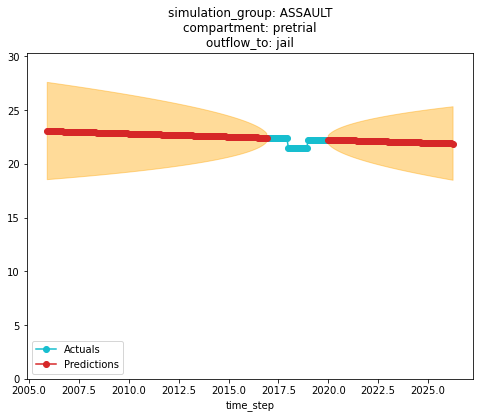

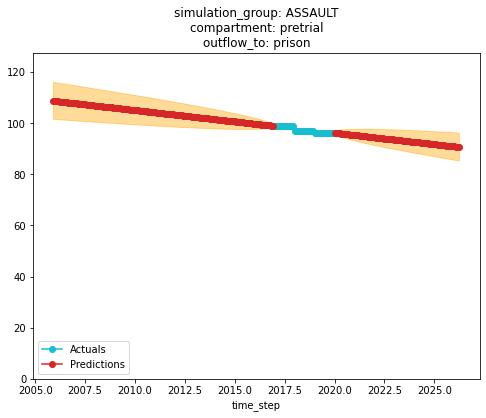

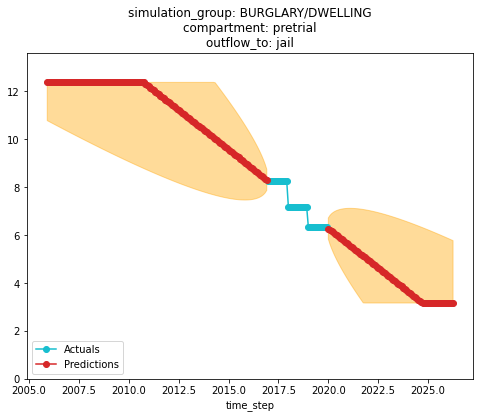

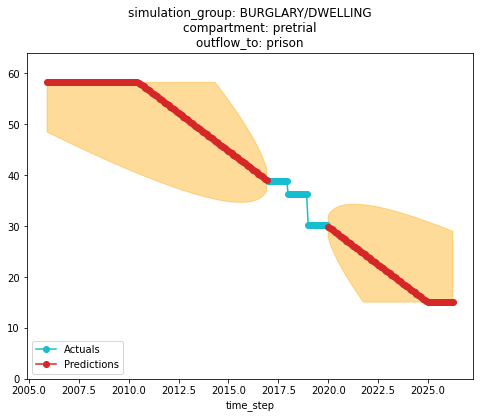

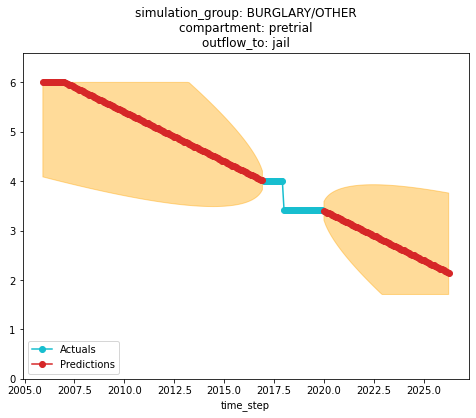

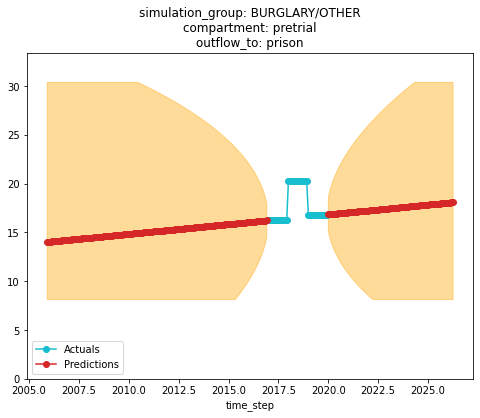

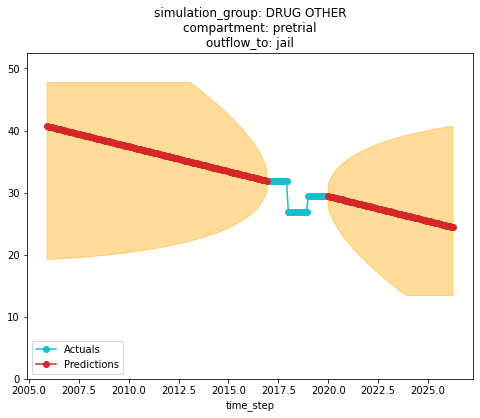

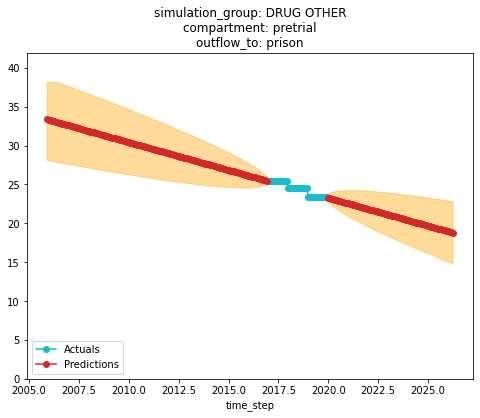

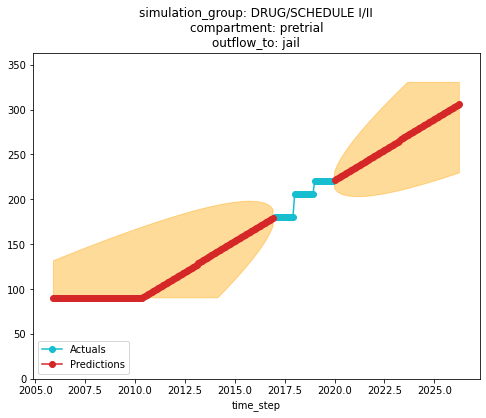

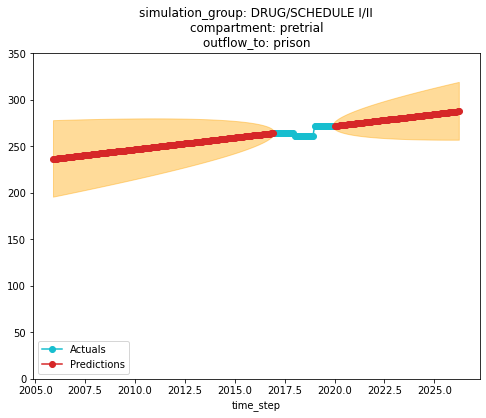

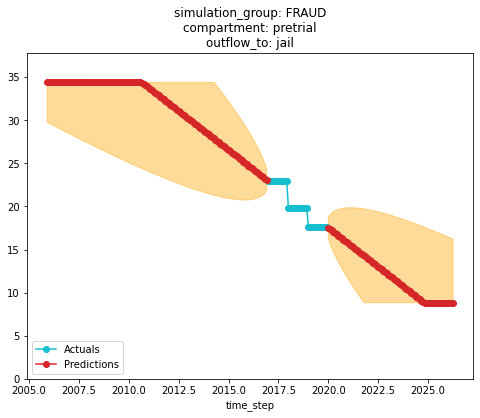

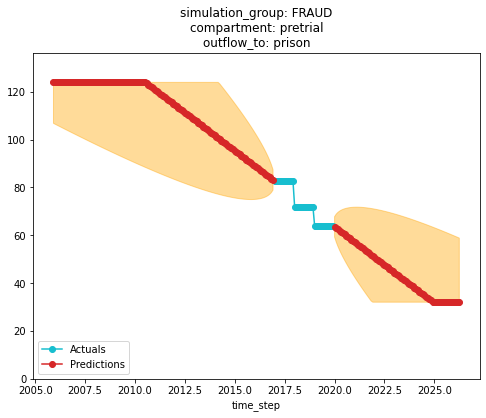

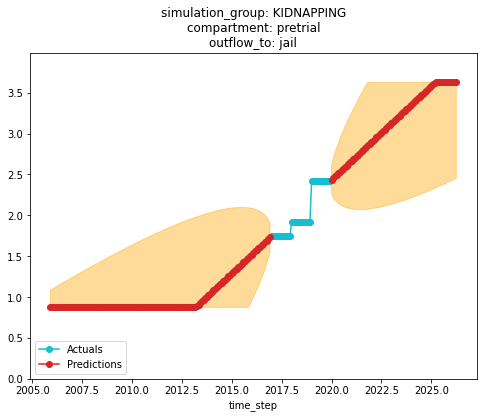

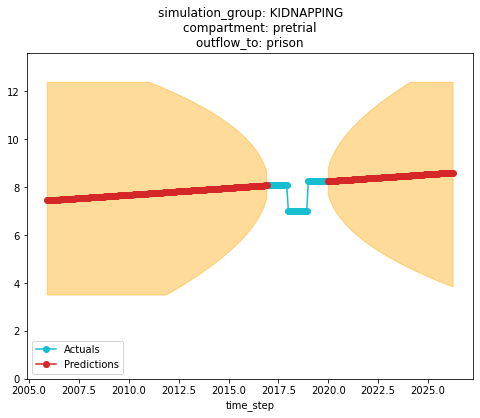

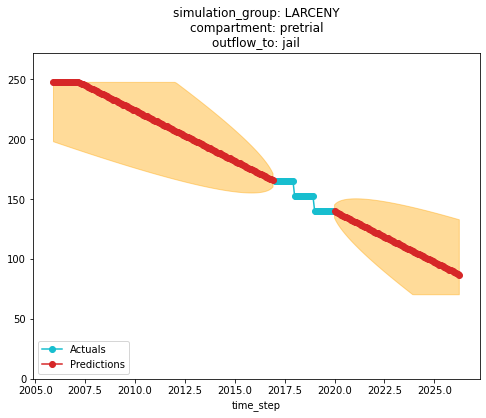

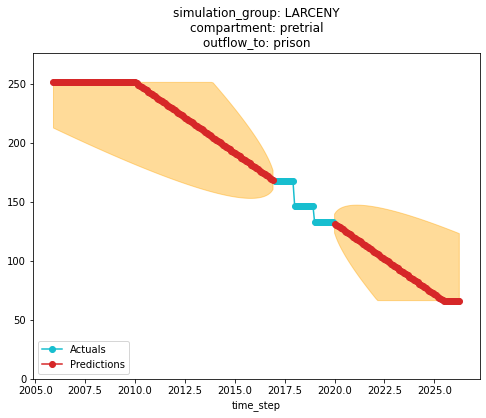

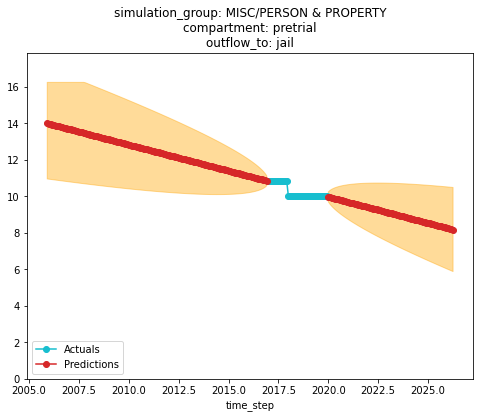

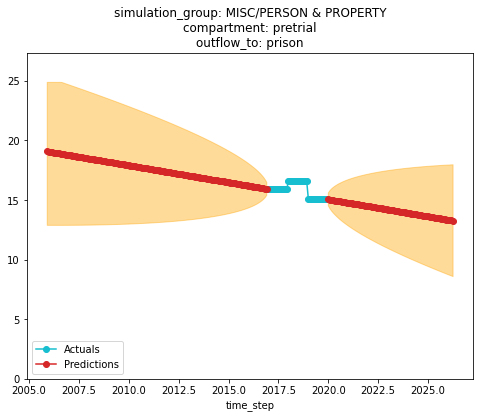

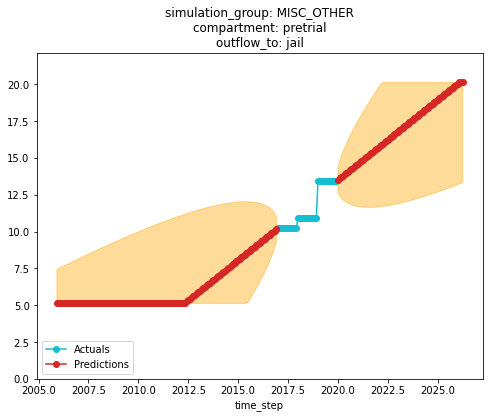

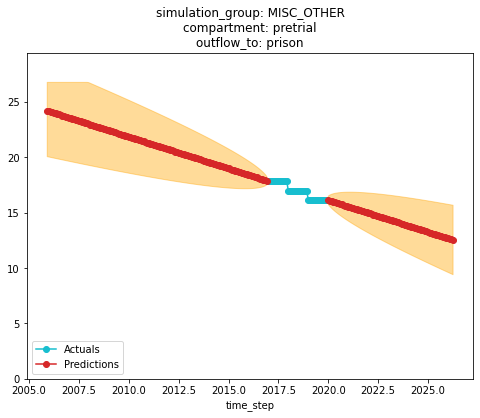

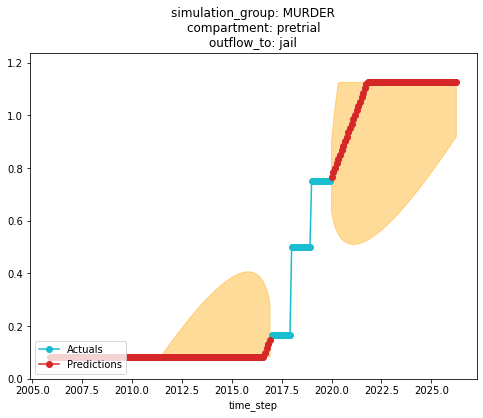

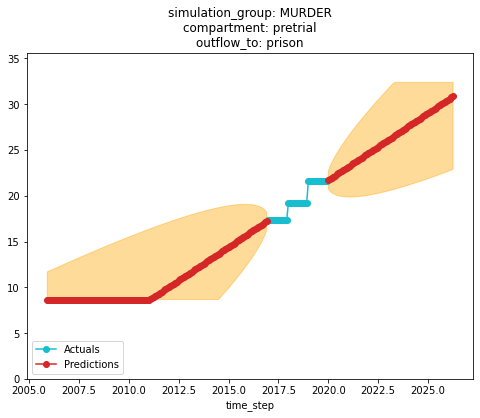

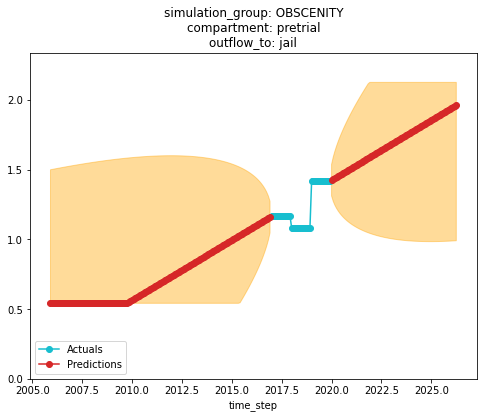

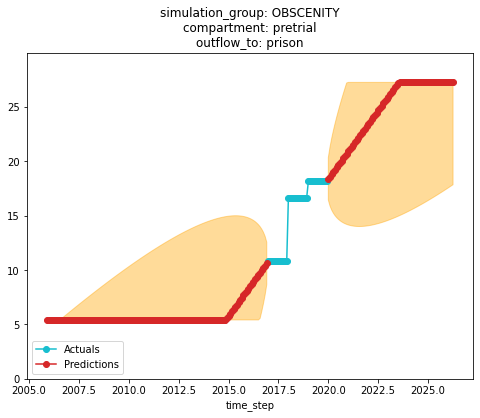

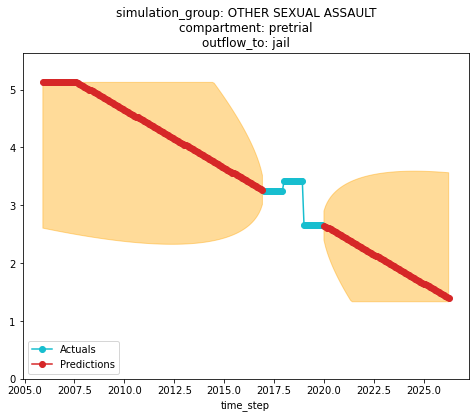

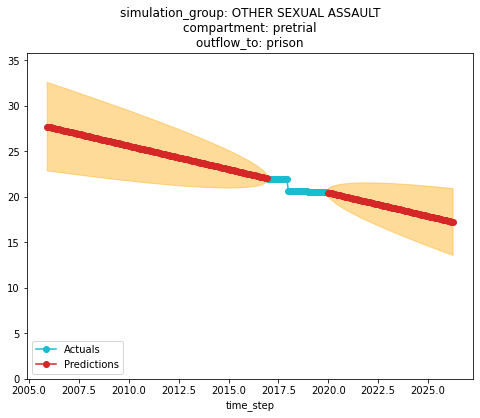

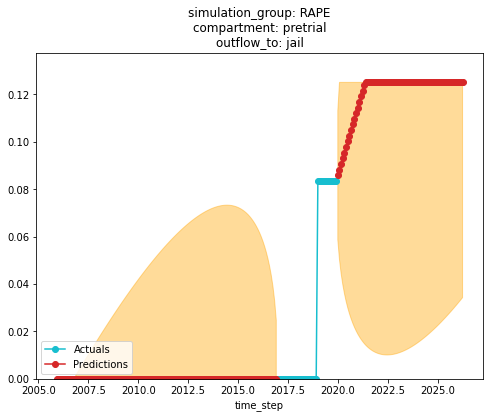

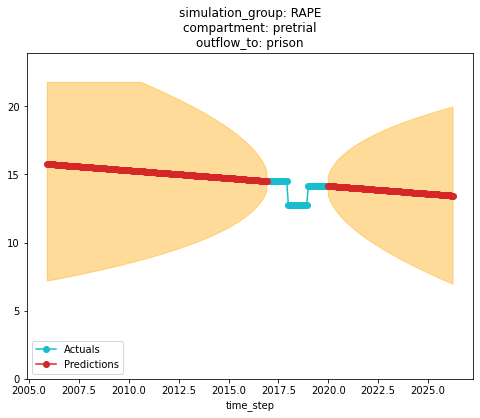

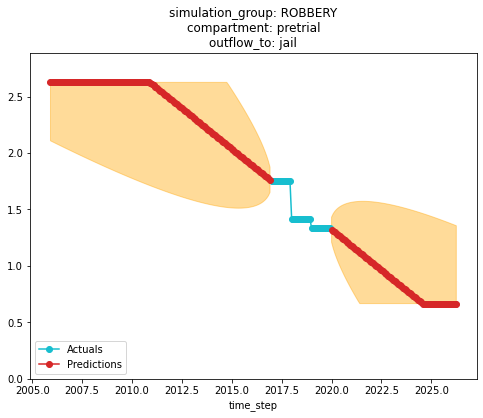

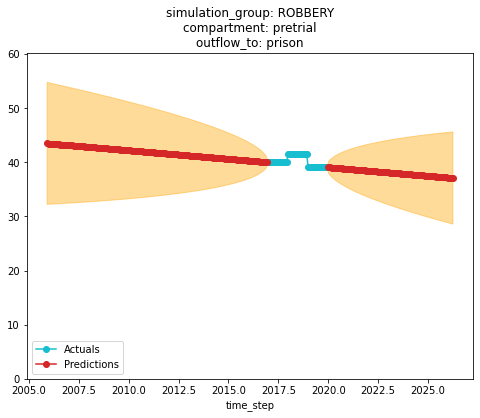

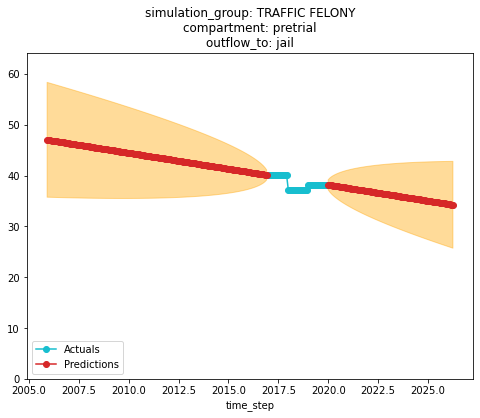

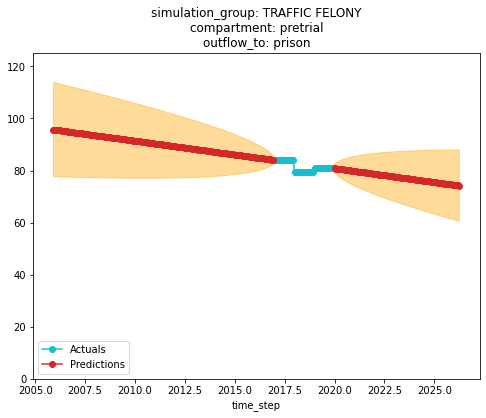

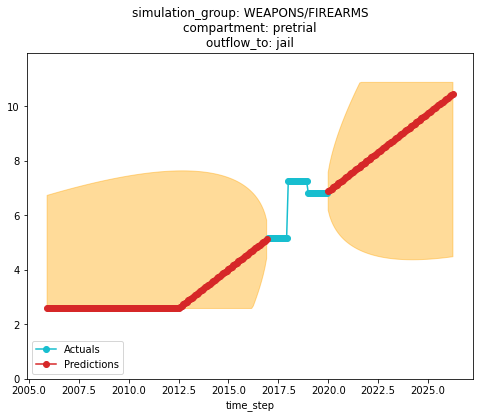

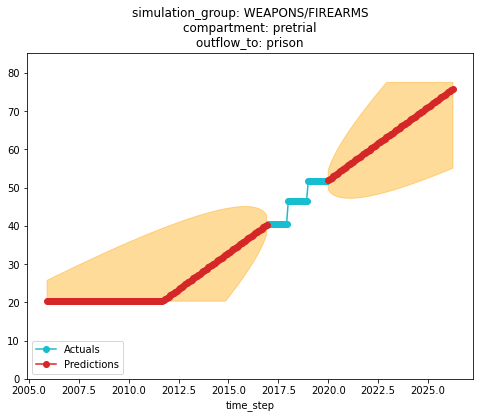

In [5]:
pd.set_option('max_rows', None)
test_sim.get_arima_output_plots('baseline_middle', by_simulation_group=True)

crime_type  compartment  outflow_to
RAPE        pretrial     jail          66.666667
dtype: float64%


initialization time:  105.38515996932983
initialization time:  89.46962785720825
simulation_time:  110.35871720314026
simulation_time:  108.92027378082275


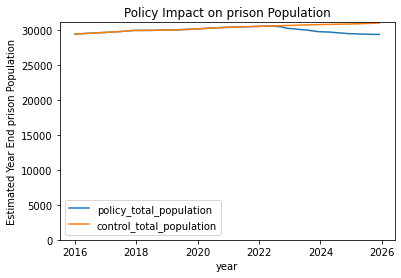

In [8]:
ELIGIBILITY = 0.61
AVG_LOS_FRACTION = 0.85
SENTENCE_REDUCTION = 0.17

# Policy Option Methods



def remove_MM(retroactive):

    return partial(TransitionTable.apply_reductions,
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'affected_fraction': [ELIGIBILITY],
                       'reduction_size': [SENTENCE_REDUCTION / AVG_LOS_FRACTION]
                   }),
                   reduction_type='*',
                   retroactive=retroactive,
                  )

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=remove_MM(False),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                policy_ts=24,
                apply_retroactive=False)
    for crime_type in test_sim.initializer.data_dict['transitions_data'].crime_type.unique()
] + [
    SparkPolicy(policy_fn=remove_MM(False),
                spark_compartment='jail',
                sub_population={'crime_type':crime_type},
                policy_ts=24,
                apply_retroactive=False)
    for crime_type in test_sim.initializer.data_dict['transitions_data'].crime_type.unique()
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

crime_type  compartment  outflow_to
RAPE        pretrial     jail          66.666667
dtype: float64%


initialization time:  126.99629306793213
initialization time:  101.28318786621094
simulation_time:  114.52788972854614
simulation_time:  113.0346302986145


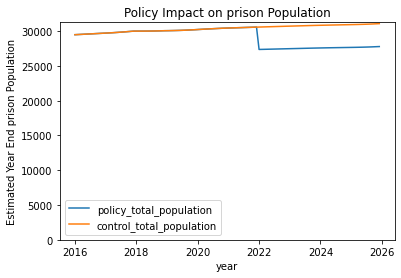

In [9]:
policy_list_non_retroactive = [
    SparkPolicy(policy_fn=remove_MM(True),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                policy_ts=24,
                apply_retroactive=True)
    for crime_type in test_sim.initializer.data_dict['transitions_data'].crime_type.unique()
] + [
    SparkPolicy(policy_fn=remove_MM(True),
                spark_compartment='jail',
                sub_population={'crime_type':crime_type},
                policy_ts=24,
                apply_retroactive=True)
    for crime_type in test_sim.initializer.data_dict['transitions_data'].crime_type.unique()
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')